El objetivo de esta tarea es:

1.   Implementar una función que permita calcular una convolución (usando **Cython**).
2.   Implementar pirámides de Gauss y Laplace.
3.   Implementar reconstruccion de una imagen a partir de las pirámides.
4.   Graficar las pirámides.

\* Nota: los arreglos (matrices) creados deben ser de tipo np.float32

# Configuraciones preliminares

## Instalación de librerías y paquetes necesarios

In [1]:
# Para medir tiempo de ejecucion
!pip install ipython-autotime

In [2]:
# Extensiones
%load_ext Cython
%load_ext autotime

time: 80.7 µs (started: 2021-10-24 23:46:37 +00:00)


In [3]:
# Paquetes a ser usados
import numpy as np
import cv2
import cython
import numpy as np
import math
# Este paquete solo se debe usar si se usa colaboratory
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

time: 543 ms (started: 2021-10-24 23:46:41 +00:00)


## Carga de archivos:

Se cargan los archivos a utilizar. Para esta actividad, es recomendado que se suban los 4 archivos ya descomprimidos del zip original.

In [12]:
!wget https://github.com/DiegoPincheiraIb/EL7008_Assignments/raw/main/Assignment_1/imagenes_tarea_1_el7008.zip

--2021-10-24 23:51:29--  https://github.com/DiegoPincheiraIb/EL7008_Assignments/raw/main/Assignment_1/imagenes_tarea_1_el7008.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DiegoPincheiraIb/EL7008_Assignments/main/Assignment_1/imagenes_tarea_1_el7008.zip [following]
--2021-10-24 23:51:29--  https://raw.githubusercontent.com/DiegoPincheiraIb/EL7008_Assignments/main/Assignment_1/imagenes_tarea_1_el7008.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 924016 (902K) [application/zip]
Saving to: ‘imagenes_tarea_1_el7008.zip’

imagenes_tarea_1_el 100%[===================>] 902.36K  --.-KB/s   

In [15]:
!unzip imagenes_tarea_1_el7008.zip

Archive:  imagenes_tarea_1_el7008.zip
 extracting: frutas.png              
 extracting: madera.png              
 extracting: poligonos.png           
  inflating: techo.png               
time: 120 ms (started: 2021-10-24 23:51:48 +00:00)


In [16]:
# Se verifica que los archivos se hayan subido correctamente
!ls

frutas.png		     madera.png     sample_data
imagenes_tarea_1_el7008.zip  poligonos.png  techo.png
time: 113 ms (started: 2021-10-24 23:52:03 +00:00)


# Funciones

Se procederá a elaborar una serie de funciones que permitan llevar a cabo los objetivos requeridos para esta actividad.

## Convolution_cython()

Esta función recibe una matriz y una máscara, retornando la convolución entre ambos elementos. Esta función ha sido programada en **Cython**.

In [17]:
%%cython
import cython
import numpy as np
cimport numpy as np

# La convolucion debe ser implementada usando cython (solo esta funcion en cython)
#@cython.boundscheck(False)
cpdef float[:, :] convolution_cython(float [:, :] input, float [:, :] mask):
  cdef int r, c, rows, cols, Rows_Mask,Cols_Mask ,Centro_Rows_Mask ,Centro_Cols_Mask 
  cdef float sum
  cdef np.ndarray output=np.zeros((input.shape[0],input.shape[1]), dtype = np.float32)

  # Tamano de la imagen
  rows = input.shape[0]
  cols = input.shape[1]

  # Tamaño de la máscara:
  Rows_Mask = mask.shape[0]
  Cols_Mask = mask.shape[1]

  Centro_Rows_Mask = Rows_Mask//2 + 1
  Centro_Cols_Mask = Cols_Mask//2 + 1

  # Se implementa convolucion entre "input" y "mask"
  for r in range(rows):
    for c in range(cols):
      sum = 0
      for index_rows_mask in range(-Centro_Rows_Mask +1, Centro_Rows_Mask):
        for index_cols_mask in range(-Centro_Cols_Mask + 1, Centro_Cols_Mask):
          Indices_Kernel_Rows = index_rows_mask + Centro_Rows_Mask -1
          Indices_Kernel_Cols = index_cols_mask + Centro_Cols_Mask -1
          new_i = r + index_rows_mask
          new_j = c + index_cols_mask
          if (new_i >=0 and new_i<rows and new_j >=0 and new_j < cols):
            sum += mask[Indices_Kernel_Rows,Indices_Kernel_Cols] * input[new_i, new_j]
      output[r, c] = sum
  return output

time: 5.09 s (started: 2021-10-24 23:52:10 +00:00)


## Kernels gaussianos

Para esta actividad se requiere convolucionar las imágenes con un Kernel Gaussiano. Este kernel tiene una propiedad particular: es posible realizar una operación equivalente a convolucionar un kernel 2D gaussiano, la cual consiste en convolucionar un kernel gaussiano horizontal de 1D con la imagen, y al resultado de dicha operación se le convoluciona un kernel gaussiano vertical de 1D.

Las funciones Compute_gauss_horiz() y Compute_gauss_vert() generan los kernels necesarios para realizar la convolución. Estos reciben un parámetro σ y el ancho del kernel, produciendo un kernel que sigue la siguiente curva:

$${\displaystyle f(x) = {\frac {1}{\sigma {\sqrt {2\pi }}}}\;e^{-{\frac {(x-\mu )^{2}}{2\sigma ^{2}}}}\,\!}$$

### Compute_gauss_horiz()

Dado un parámetro σ y un ancho determinado, genera una máscara horizontal cuyos valores forman una gaussiana.

In [18]:
def compute_gauss_horiz(σ, width):
	Mascara = np.zeros((1, width), np.float32) # Se inicializa la máscara
	Valor_Central = width//2 # Se calcula el valor central
	for i in range(width): # Se itera sobre la máscara
		Exponencial = math.exp((-1/(2*σ**2)) * (i - Valor_Central)**2 ) # Se calcula la exponencial
		Mascara[0,i] =  (1/(σ * np.sqrt(2*np.pi))) * Exponencial # Se divide por 
	Suma = sum(Mascara.T)
	Mascara_Final = Mascara/Suma # Se normaliza
	return Mascara_Final

time: 6.57 ms (started: 2021-10-24 23:52:15 +00:00)


### Compute_gauss_vert()

Dado un parámetro σ y una altura determinada, genera una máscara vertical cuyos valores forman una gaussiana.

In [19]:
def compute_gauss_vert(σ, height):
	Mascara = np.zeros((height, 1), np.float32)
	Valor_Central = height//2 # Se calcula el valor central
	for i in range(height): # Se itera sobre la máscara
		Exponencial = math.exp((-1/(2*σ**2)) * (i - Valor_Central)**2 ) # Se calcula la exponencial
		Mascara[i,0] =  (1/(σ * np.sqrt(2*np.pi))) * Exponencial # Se divide por 
	Suma = sum(Mascara)
	Mascara_Final = Mascara/Suma # Se normaliza
	return Mascara_Final

time: 8.08 ms (started: 2021-10-24 23:52:15 +00:00)


## Do_blur()

Dado una imagen en formato de matriz, un parámetro σ y un largo del Kernel deseado (se asume que el Kernel objetivo es cuadrado, por lo que el largo del Kernel es igual al ancho del Kernel), genera las máscaras horizontales y verticales del Kernel gaussiano objetivo y las convoluciona con la matriz de entrada, provocando una **difuminación** de la imagen de entrada.

In [20]:
def do_blur(input, σ, height):
	Mascara_Horiz = compute_gauss_horiz(σ,height) # Máscara gauss. horizontal
	Mascara_Vert = compute_gauss_vert(σ,height) # Máscara gauss. vertical
	Intermedio = convolution_cython(input,Mascara_Horiz) # Conv. entre input y máscara horizontal
	Output = convolution_cython(Intermedio,Mascara_Vert) # Conv. entre resultado y máscara horizontal
	return Output

time: 5.63 ms (started: 2021-10-24 23:52:15 +00:00)


## Imagen_Plot()

In [21]:
def Imagen_Plot(Matriz_Obj, Gris=False):
  if Gris == False:
    plt.imshow(Matriz_Obj[...,::-1])
  else:
    plt.imshow(Matriz_Obj, cmap='gray')
  plt.show()

time: 7.59 ms (started: 2021-10-24 23:52:15 +00:00)


## Función Subsample()

Esta función realiza un submuestreo de una matriz "input", tomando las filas y columnas pares de esta.

In [22]:
def subsample(input):
	Input_Aux = np.copy(input)
	Filas_Submuestreo = len(input)//2
	Col_Submuestreo = len(input[0])//2
	Resultado = np.zeros((Filas_Submuestreo,Col_Submuestreo),dtype = np.float32)
	for i in range(0, len(input)): # Filas
		if i % 2 == 0: # Realiza operaciones solo si la fila es par:
			for j in range(0, len(input[0])): # Columnas
				if j % 2 == 0: # Realiza operaciones solo si la columna es impar:
					Resultado[i//2,j//2] = input[i,j]
	return Resultado

time: 10.9 ms (started: 2021-10-24 23:52:15 +00:00)


## Piramide Gaussiana

Se procederá a crear dos funciones: La primera, Compute_Gauss_Pyramid() crea una Pirámide Gaussiana de **n** niveles a partir de una imagen de entrada, mientras que Show_gauss_pyramid() entrega las imágenes contenidas en los pisos de una determinada pirámide de Gauss.

### Compute_Gauss_pyramid()

Dado una imagen de entrada en forma de matriz y un entero, genera una lista que contiene imágenes correspondientes a la pirámide de Gauss calculada a la entrada con una determinada cantidad de pisos.

In [23]:
def compute_gauss_pyramid(input, nlevels):  
  gausspyramid = [] # Se inicializa la lista final
  current = np.copy(input)
  gausspyramid.append(current) # Se añade el primer piso
  for i in range(1,nlevels):
    current_intermedio = do_blur(gausspyramid[i-1], 2.0, 7) # Se difumina el piso i-1 utilizando do_blur()
    current = subsample(current_intermedio) # Se submuestrea el resultado
    gausspyramid.append(current) # Se añade a la lista
  return gausspyramid

time: 7.29 ms (started: 2021-10-24 23:52:15 +00:00)


### Show_gauss_pyramid():

Esta función muestra las imágenes contenidas en una pirámide de Gauss.

In [24]:
def show_gauss_pyramid(pyramid):
  for imagen_piramide in pyramid: # Itera en la lista
    cv2_imshow(imagen_piramide) # Muestra las imágenes contenidas en la lista

time: 3.43 ms (started: 2021-10-24 23:52:15 +00:00)


## Suma, resta, y escala de valor abs

Se construyen a continuación funciones auxiliares que permiten operar dos matrices entre sí, o una matríz y un factor determinado.

### Substract():

Esta función resta **pixel a pixel** dos matrices, con la condición que ambas tengan el mismo tamaño.

In [25]:
def subtract(input1, input2):
  assert input1.shape == input2.shape # Verifica que los inputs sean del mismo tamaño.
  Output = np.zeros(input1.shape, dtype=np.float32) # Inicializa la matriz de entrada
  for row in range(input1.shape[0]): # Se itera por cada fila
    for col in range(input1.shape[1]): # Se itera por cada columna
      Output[row,col] = input1[row,col] - input2[row,col] # El pixel de la imagen de salida corresponde a la resta de los pixeles de los inputs en esa ubicación
  return Output

time: 8.2 ms (started: 2021-10-24 23:52:15 +00:00)


### Add()

Esta función suma **pixel a pixel** dos matrices, con la condición que ambas tengan el mismo tamaño.

In [26]:
def add(input1, input2):
  assert input1.shape == input2.shape # Verifica que los inputs sean del mismo tamaño.
  Output = np.zeros(input1.shape, dtype=np.float32) # Inicializa la matriz de entrada
  for row in range(input1.shape[0]): # Se itera por cada fila
    for col in range(input1.shape[1]): # Se itera por cada columna
      Output[row,col] = input1[row,col] + input2[row,col] # El pixel de la imagen de salida corresponde a la suma de los pixeles de los inputs en esa ubicación
  return Output

time: 10.4 ms (started: 2021-10-24 23:52:15 +00:00)


### Scale_abs()

Esta función escala una imagen **pixel a pixel** dado un parámetro.

In [27]:
def scale_abs(input, factor):
  Output = np.zeros(input.shape, dtype=np.float32)
  for row in range(input.shape[0]): # Se itera por cada fila
    for col in range(input.shape[1]): # Se itera por cada columna
      Output[row,col] = np.abs(input[row,col]) * factor # Se aplica valor absoluto al pixel, y se escala usando el factor
  return Output

time: 3.14 ms (started: 2021-10-24 23:52:15 +00:00)


## Pirámide de Laplace

Se procederá a crear dos funciones: La primera, Compute_Laplace_Pyramid() crea una Pirámide de Laplace de **n** niveles a partir de una imagen de entrada, mientras que Show_Laplace_pyramid() entrega las imágenes contenidas en los pisos de una determinada pirámide de Laplace.

### Compute_laplace_pyramid()

Dado una imagen de entrada en forma de matriz y un entero, genera una lista que contiene imágenes correspondientes a la pirámide de Laplace calculada a la entrada con una determinada cantidad de pisos.

In [28]:
def compute_laplace_pyramid(input, nlevels):
  gausspyramid = [] # Se inicializa
  laplacepyramid = []
  current = np.copy(input)
  gausspyramid.append(current)
  for i in range(1, nlevels):
    # 1) Se aplica do_blur( ) a la imagen gausspyramid[i-1], con sigma 2.0 y ancho 7
    current_intermedio = do_blur(gausspyramid[i-1],2.0,7)
    # 2) Se guarda en laplacepiramid el resultado de restar gausspyramid[i - 1] y la imagen calculada en (1)
    laplacepyramid.append(subtract(gausspyramid[i-1],current_intermedio))
    # 3) Se submuestrea la imagen calculada en (1), y se guarda el resultado en current
    current = subsample(current_intermedio)
    gausspyramid.append(current)
  laplacepyramid.append(current)  # Se agrega el ultimo piso de la piramide de Laplace
  return laplacepyramid

time: 10.5 ms (started: 2021-10-24 23:52:15 +00:00)


### Show_laplace_pyramid()

Esta función muestra las imágenes contenidas en una pirámide de Laplace.

In [29]:
def show_laplace_pyramid(pyramid):
    for imagen_piramide in pyramid[:-1]: # Se itera por todos los pisos menos el último
      cv2_imshow(scale_abs(imagen_piramide,6)) # Se escala la imagen contenida en el piso y se muestra con cv2_imshow()
    cv2_imshow(pyramid[-1]) #  La ultima imagen del ultimo piso se muestra tal cual

time: 2.61 ms (started: 2021-10-24 23:52:15 +00:00)


## Upsample()

Esta función sobremuestrea una matriz, siendo los pixeles de salida productos de una **interpolación** utilizando el promedio de los 4 pixeles más cercanos del pixel objetivo en la imagen de entrada.

In [30]:
def upsample(input):
  Intermedio = np.zeros((input.shape[0]*2,input.shape[1]*2),dtype=np.float32)
  Output = np.copy(Intermedio)
  for row in range(input.shape[0]):
    for col in range(input.shape[1]):
        Intermedio[row*2:row*2 +2,col*2:col*2 +2] = input[row,col] # Duplicacion del tamaño de imagen pixel a pixel
  # Un pixel de la imagen de salida debe ser el promedio de los 4 pixeles mas cercanos de la imagen de entrada
  for row in range(Intermedio.shape[0]-1):
    for col in range(Intermedio.shape[1]-1):
      if row < Intermedio.shape[0] and col < Intermedio.shape[1]:
        Output[row,col] = (Intermedio[row,col]+Intermedio[row+1,col]+Intermedio[row,col+1] + Intermedio[row+1,col+1])*1/4
      elif row == Intermedio.shape[0] and col == Intermedio.shape[1]:
        Output[row,col] = (Intermedio[row,col]+Intermedio[row-1,col]+Intermedio[row,col-1] + Intermedio[row-1,col-1])*1/4
      elif row == Intermedio.shape[0] and col < Intermedio.shape[1]:
        Output[row,col] = (Intermedio[row,col]+Intermedio[row-1,col]+Intermedio[row,col+1] + Intermedio[row-1,col+1])*1/4
      else:
        Output[row,col] = (Intermedio[row,col]+Intermedio[row+1,col]+Intermedio[row,col-1] + Intermedio[row+1,col-1])*1/4
  # Se debe tener cuidado de que los indices no salgan fuera del tamano de la imagen
  return Output

time: 23 ms (started: 2021-10-24 23:52:15 +00:00)


## Reconstruct():

Esta función hace uso de una pirámide de Laplace y la función upsample() para **reconstruir** una imagen a partir de dicha pirámide.

In [31]:
def reconstruct(laplacepyramid):
  output = np.copy( laplacepyramid[len(laplacepyramid)-1] )
  print(output.shape)
  for i in range(1, len(laplacepyramid)): # Se itera por los pisos de la piramide de Laplace
    lev = int(len(laplacepyramid)) - i - 1
    # Se duplica el tamano de output con upsample(), se añade a laplacepyramid[lev] usando add(), y se guarda en output:
    output = add(laplacepyramid[lev],upsample(output))
  return output

time: 5.11 ms (started: 2021-10-24 23:52:15 +00:00)


# Ejecución

Se procede a leer las imágenes de manera individual. Se convierten a escalas de grises, y se calculan las pirámides de Gauss y Laplace con 5 pisos cada una. Posteriormente se reconstruye la imagen usando la pirámide de Laplace generada.

Piramide de gauss:


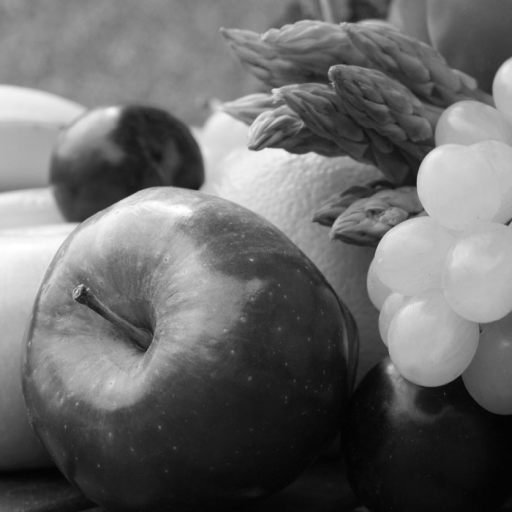

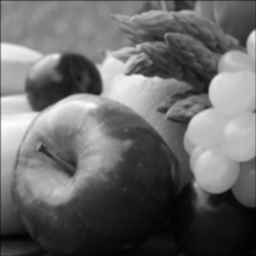

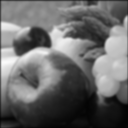

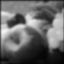

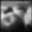

Piramide de laplace:


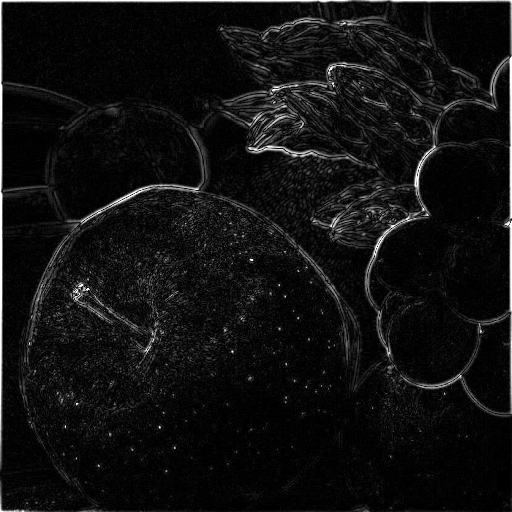

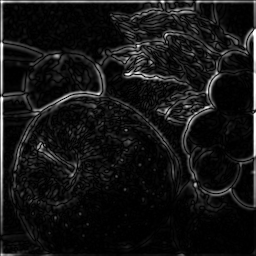

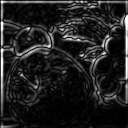

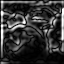

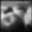

Imagen reconstruida:
(32, 32)


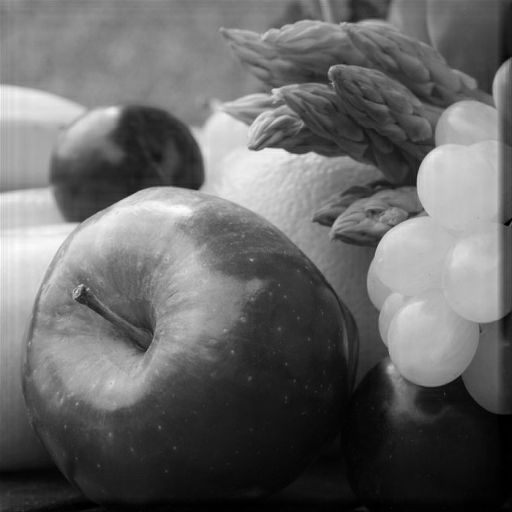

Imagen original:


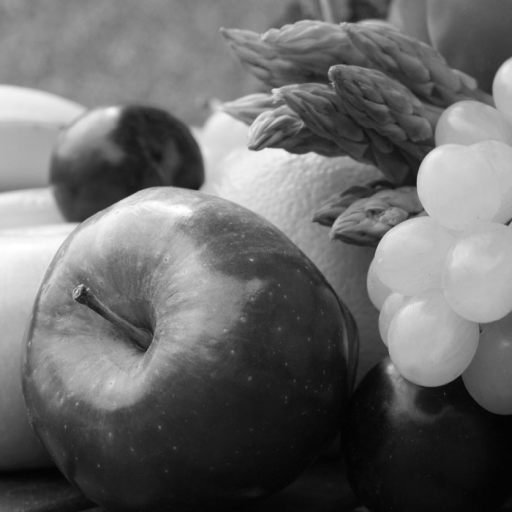

Shape de imagen reconstruida:  (512, 512)
Shape de imagen original:  (512, 512)
Piramide de gauss:


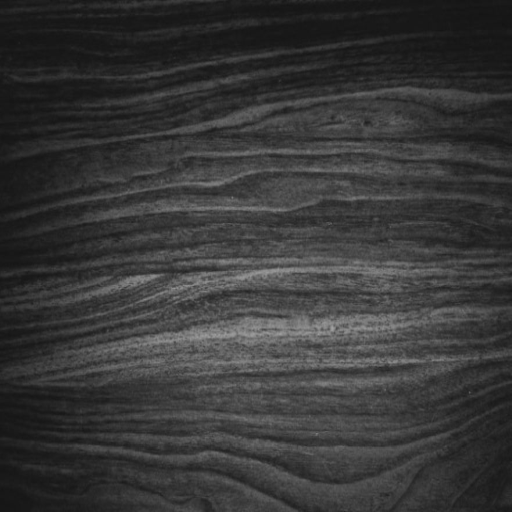

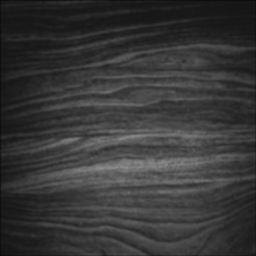

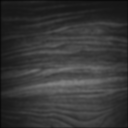

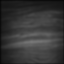

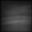

Piramide de laplace:


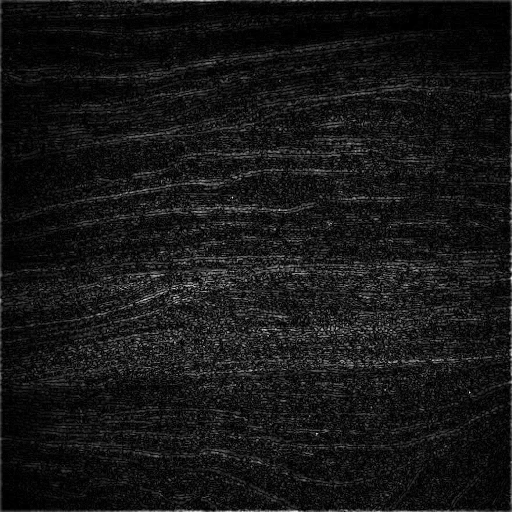

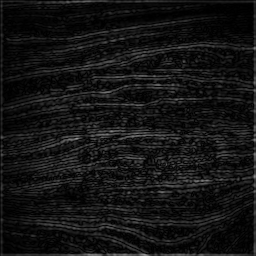

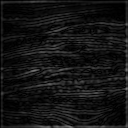

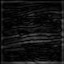

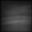

Imagen reconstruida:
(32, 32)


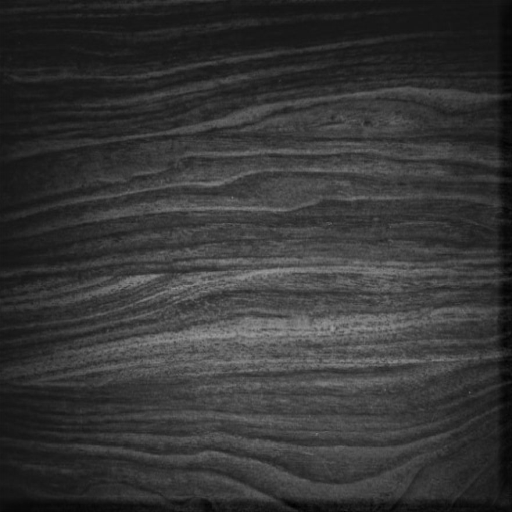

Imagen original:


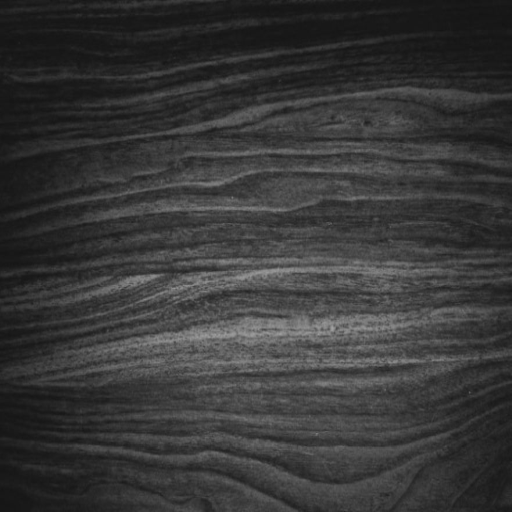

Shape de imagen reconstruida:  (512, 512)
Shape de imagen original:  (512, 512)
Piramide de gauss:


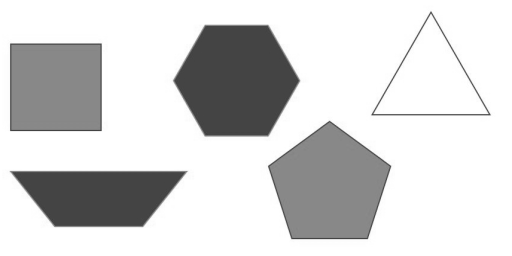

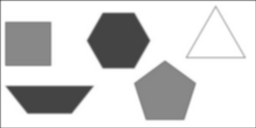

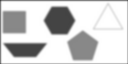

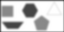

Piramide de laplace:


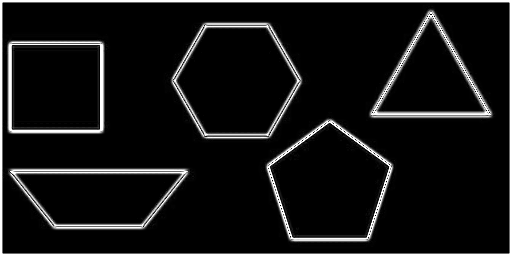

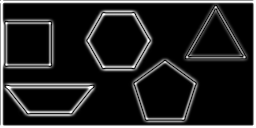

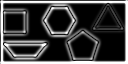

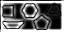

Imagen reconstruida:
(16, 32)


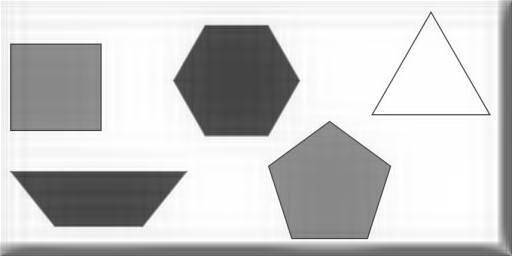

Imagen original:


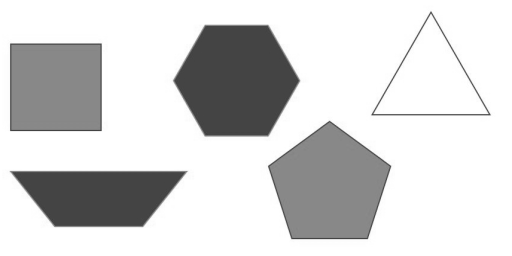

Shape de imagen reconstruida:  (256, 512)
Shape de imagen original:  (256, 512)
Piramide de gauss:


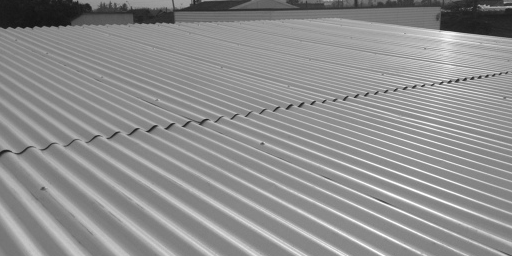

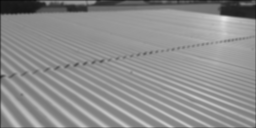

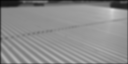

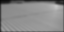

Piramide de laplace:


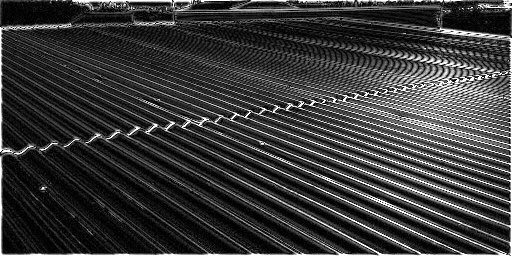

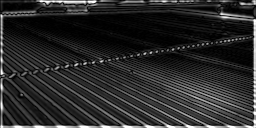

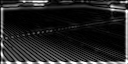

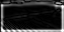

Imagen reconstruida:
(16, 32)


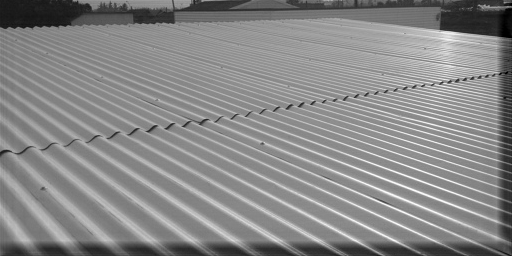

Imagen original:


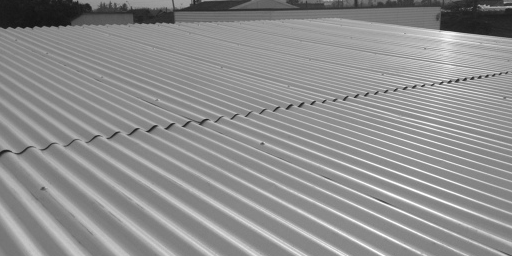

Shape de imagen reconstruida:  (256, 512)
Shape de imagen original:  (256, 512)
time: 26 s (started: 2021-10-24 23:52:15 +00:00)


In [32]:
Lista_Imgs = ['frutas.png','madera.png','poligonos.png','techo.png']

for i in Lista_Imgs:
  originalRGB = cv2.imread(i)
  if originalRGB is None:
    assert False, 'Imagen no encontrada'

  if len(originalRGB.shape) == 3:
    original = cv2.cvtColor(originalRGB, cv2.COLOR_BGR2GRAY)
  else:
    original = originalRGB

  input = np.float32( original )

  print('Piramide de gauss:')
  gausspyramid = compute_gauss_pyramid(input, 5)
  show_gauss_pyramid(gausspyramid)

  print('Piramide de laplace:')
  laplacepyramid = compute_laplace_pyramid(input, 5)
  show_laplace_pyramid(laplacepyramid)

  print('Imagen reconstruida:')
  reconstr = reconstruct(laplacepyramid)
  cv2_imshow(reconstr)

  print('Imagen original:')
  cv2_imshow(original)

  print('Shape de imagen reconstruida: ', reconstr.shape)
  print('Shape de imagen original: ', input.shape)